In [3]:
import xarray as xr
from xmitgcm import open_mdsdataset
import xgcm
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt
import matplotlib.animation as animation
from fastjmd95 import rho
import sys
warnings.filterwarnings("ignore")

ds = xr.open_dataset('~/TPOSE6_Daily_2012.nc',engine='netcdf4')

In [10]:
'''
u_transport = ds.UVEL * ds.dyG * ds.hFacW * ds.drF
v_transport = ds.VVEL * ds.dxG * ds.hFacS * ds.drF

W_from_div_uv = -(grid.diff(u_transport, 'X') + grid.diff(v_transport, 'Y')) / ds.rA
'''

# ds.W_from_div_uv.plot()
sigma_0 = (rho(ds.SALT, ds.THETA, 0)-1000)

# print('barotropic flow') # depth average
barotropic_w = -1*ds.W_from_div_uv.mean(dim='z')
baroclinic_w = -1*ds.W_from_div_uv - barotropic_w

# TIW filter
fs = 1/86400
lowF = (1/15)*fs # equivalent to 15 days per cycle
order = 4
sos = butter(order, lowF, 'highpass', fs=fs, output='sos')
baroclinic_w_filt = sosfiltfilt(sos, baroclinic_w.values, axis=1)

tmp = ds.WVEL.copy(deep=True)
tmp.values = baroclinic_w_filt
tmp.name = 'baroclinic_w_filt'
baroclinic_w_filt = tmp 

In [11]:
dudz = (ds.UVEL[1:,:,:,:].values - ds.UVEL[:-1,:,:,:].values)/(ds.z[1:].values[:,np.newaxis,np.newaxis,np.newaxis]-ds.z[:-1].values[:,np.newaxis,np.newaxis,np.newaxis])
dvdz = (ds.VVEL[1:,:,:,:].values - ds.VVEL[:-1,:,:,:].values)/(ds.z[1:].values[:,np.newaxis,np.newaxis,np.newaxis]-ds.z[:-1].values[:,np.newaxis,np.newaxis,np.newaxis])

tmp = ds.UVEL[:-1,:,:,:].copy(deep=True)
tmp.values = dudz
tmp.name = 'dudz'
dudz = tmp 

tmp = ds.VVEL[:-1,:,:,:].copy(deep=True)
tmp.values = dvdz
tmp.name = 'dvdz'
dvdz = tmp 

shear_2 = dudz**2 + dvdz**2

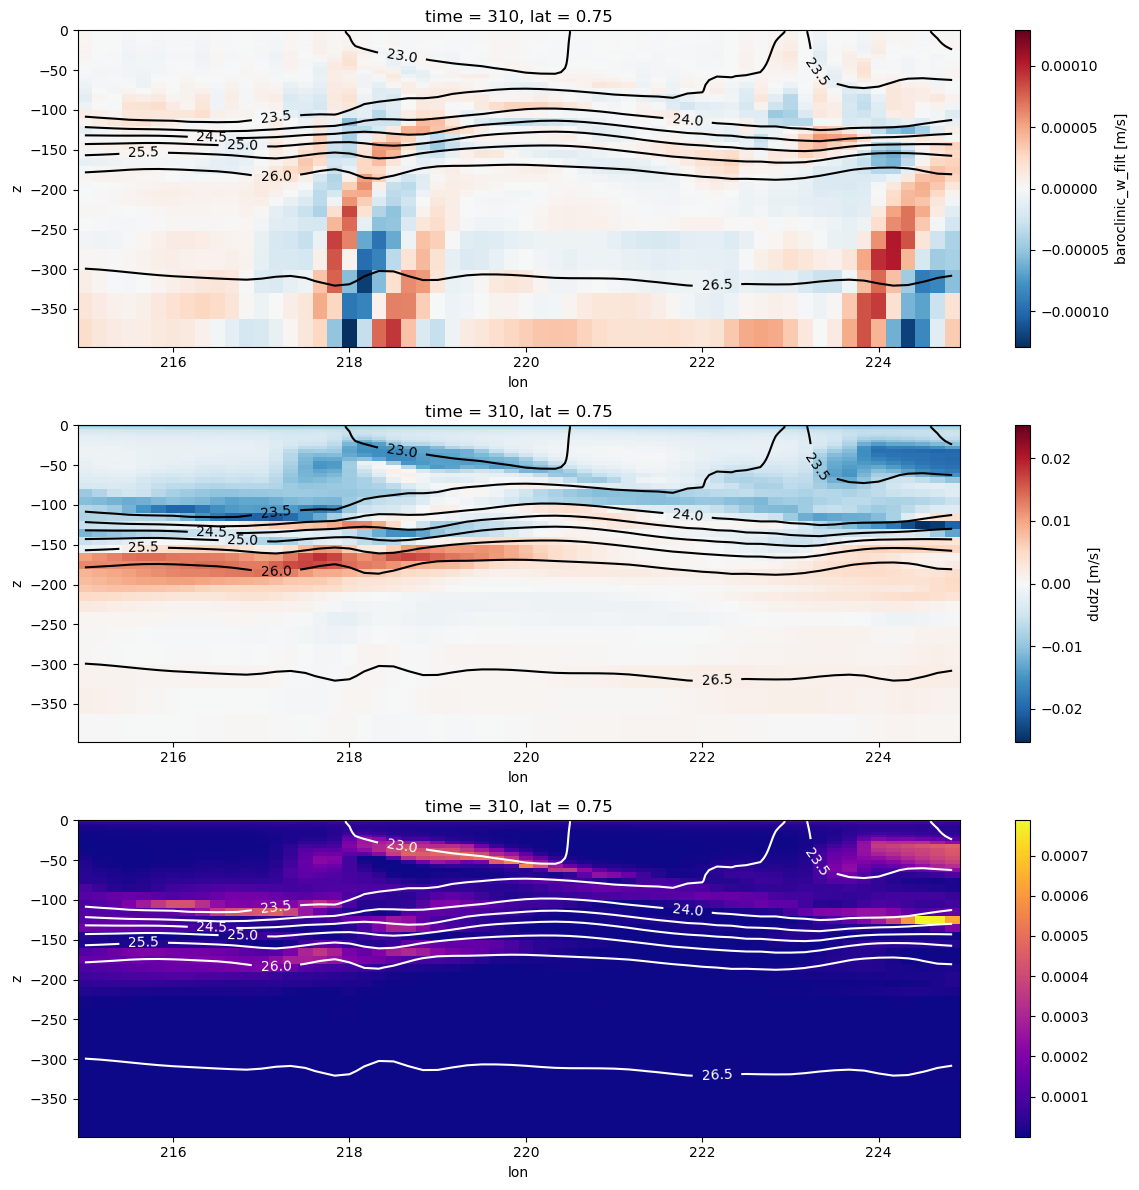

In [12]:
sigma_plot = sigma_0.sel(time=[310.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()

fig, ax = plt.subplots(figsize=(12,12),nrows=3)
baroclinic_w_filt.sel(time=[310.0],lat=[1.0],method='nearest').sel(z=slice(0,-400)).plot(ax=ax[0],cmap='RdBu_r')
ax[0].set_title('w\'')
CS = sigma_plot.plot.contour(ax=ax[0],levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[0].clabel(CS)

dudz.sel(time=[310.0],lat=[1.0],method='nearest').sel(z=slice(0,-400)).plot(ax=ax[1],cmap='RdBu_r')
ax[1].set_title('du/dz')
CS = sigma_plot.plot.contour(ax=ax[1],levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[1].clabel(CS)

shear_2.sel(time=[310.0],lat=[1.0],method='nearest').sel(z=slice(0,-400)).plot(ax=ax[2],cmap='plasma')
ax[2].set_title('Shear Squared')
CS  = sigma_plot.plot.contour(ax=ax[2],levels=np.arange(23.0,28.5,0.5),colors='w',linewidths=1.5, kwargs=dict(inline=True))
ax[2].clabel(CS)


plt.tight_layout()